# Movie Ratings - Classification Model

In [1]:
# Import initial dependencies
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
# Import movies dataframe
movies = pd.read_csv("https://data-bootcamp-ztc.s3.amazonaws.com/movies_complete_cleaned.csv")

awards = pd.read_csv(
    "https://data-bootcamp-ztc.s3.amazonaws.com/parsed_awards_table.csv"
)

In [8]:
movies_sel = movies[["name", "plot"]]

awards_sel = awards[["name", "oscar wins and nominations"]]

awards_sel["oscar_nom"] = [
    1 if x != 0 else 0 for x in awards_sel["oscar wins and nominations"]
]

df = pd.merge(movies_sel, awards_sel, how="left", on="name")

df.set_index("name", inplace=True)

df.drop(["oscar wins and nominations"], axis=1, inplace=True)

df = df.dropna(axis='index', subset=['plot'])

df.head()

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,plot,oscar_nom
name,,
Doctor Strange,"Marvel's ""Doctor Strange"" follows the story of...",1
Sleight,A young street magician (Jacob Latimore) is le...,0
Silence,The story of two Catholic missionaries (Andrew...,1
Manchester by the Sea,"Lee Chandler is a brooding, irritable loner wh...",1
Dirty Grandpa,"Jason Kelly, the grandson of Dick Kelly, loses...",0


## Cleaning Data for Tokenization

In [15]:
df["plot_len"] = [len(x) for x in df["plot"]]

In [16]:
# Remove punctuation
import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)


df["plot"] = [remove_punct(x) for x in df["plot"]]

In [17]:
# Remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


df["plot"] = [remove_stopwords(x) for x in df["plot"]]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniellepintacasi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df

,plot,oscar_nom,plot_len
name,,,
Doctor Strange,marvels doctor strange follows story talented ...,1,365
Sleight,young street magician jacob latimore left care...,0,181
Silence,story two catholic missionaries andrew garfiel...,1,176
Manchester by the Sea,lee chandler brooding irritable loner works ha...,1,294
Dirty Grandpa,jason kelly grandson dick kelly loses grandmot...,0,226
...,...,...,...
Hoosiers,based true story smalltown indiana team made s...,1,165
Off Beat,traumatised paramedic looks woman dreams,0,40
Big Trouble in Little China,truck driver jack burton arrives chinatown san...,0,577


### Encoding Genre and converting it into a matrix

In [19]:
genres = pd.read_csv("https://data-bootcamp-ztc.s3.amazonaws.com/parsed_genres_table.csv")  # one hot encoding genres
genres.set_index("name", inplace = True)
genres = genres.drop(columns = ["genre_kaggle", "genres_omdb"])
genres.head(3)

,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,biography,romance,...,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
name,,,,,,,,,,,,,,,,,,,,,
Doctor Strange,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sleight,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Silence,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
clean_df = pd.merge(df, genres, how = "inner", on = "name")
clean_df.head(2)

,plot,oscar_nom,plot_len,action,adventure,fantasy,sci-fi,crime,drama,history,...,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
name,,,,,,,,,,,,,,,,,,,,,
Doctor Strange,marvels doctor strange follows story talented ...,1,365,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sleight,young street magician jacob latimore left care...,0,181,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Split Data

In [25]:
from sklearn.model_selection import train_test_split

X = clean_df.drop(columns=["oscar_nom"])
y = clean_df["oscar_nom"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

## Tokenization

In [26]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# hash plot
cv = HashingVectorizer().fit(X_train["plot"])
X_train_counts = cv.transform(X_train["plot"])
X_test_counts = cv.transform(X_test["plot"])

# pass the hashed vector through a tfidf transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_test_tfidf = tf_transformer.transform(X_test_counts)

print("------------------------------")
print(f"Type: {type(X_train_tfidf)}")
print(f"Shape : {X_train_tfidf.shape}")
print("------------------------------")
print("See one vector to check: \n")
print(X_train_tfidf)

"""alternative vectorizor"""
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer().fit(X_train["plot"])


# X_train_tfidf = vectorizer.transform(X_train["plot"])
# X_test_tfidf = vectorizer.transform(X_test["plot"])


------------------------------
Type: <class 'scipy.sparse.csr.csr_matrix'>
Shape : (4730, 1048576)
------------------------------
See one vector to check: 

  (0, 1008019)	0.15439978665433857
  (0, 978383)	-0.16524822010372042
  (0, 952279)	-0.09656825155158973
  (0, 951600)	-0.20239661428095923
  (0, 944171)	0.22805092783536635
  (0, 942704)	-0.11725139247709974
  (0, 884299)	0.17379510383915275
  (0, 858859)	-0.14319349184951963
  (0, 845159)	0.1770388903003689
  (0, 739077)	0.10990097240844852
  (0, 661528)	0.09497578602954877
  (0, 654278)	0.1770388903003689
  (0, 638338)	-0.17348084672958483
  (0, 620993)	-0.1812471626459273
  (0, 600105)	-0.13105042404348044
  (0, 577738)	0.11505148150127355
  (0, 529134)	0.11377593072988282
  (0, 484920)	-0.07209069502798023
  (0, 456160)	-0.20769037339290924
  (0, 448931)	-0.09189366849650943
  (0, 439577)	0.14067299801098704
  (0, 398019)	-0.16103994775816202
  (0, 384813)	-0.15168116631977857
  (0, 299353)	0.20239661428095923
  (0, 199108)	-0

'alternative vectorizor'

In [27]:
# These features and y values are chosen to be scaled because the data is heavily skewed
from sklearn.preprocessing import MinMaxScaler

# Transform selected X ('runtime', 'votes_imdb', 'adjusted_budget')
X_scaler = MinMaxScaler().fit(X_train["plot_len"].values.reshape(-1,1))

X_train["plot_len"] = X_scaler.transform(X_train["plot_len"].values.reshape(-1,1))
X_test["plot_len"] = X_scaler.transform(X_test["plot_len"].values.reshape(-1,1))

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#create matrix with other features data

import numpy as np
from scipy.sparse import csr_matrix

X_train_extra_features_mat = csr_matrix(X_train.drop(columns=["plot"])) #run these lines to include plot len
X_test_extra_features_mat = csr_matrix(X_test.drop(columns=["plot"])) #run these lines to include plot len
# X_train_extra_features_mat = csr_matrix(X_train.drop(columns=["plot", "plot_len"]))
# X_test_extra_features_mat = csr_matrix(X_test.drop(columns=["plot", "plot_len"]))
X_train_extra_features_mat.todense()

matrix([[0.13598834, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.21806702, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.135017  , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.09567751, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10927635, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.11704711, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [29]:
#combine both matices 
from scipy.sparse import hstack

X_train_full = hstack([X_train_tfidf, X_train_extra_features_mat])
X_test_full = hstack([X_test_tfidf, X_test_extra_features_mat])

print(X_train_full.shape)
print(X_test_full.shape)

(4730, 1048601)
(1183, 1048601)


### Train and Fit Model

In [32]:
"""
with genres no balancing
"""
# Support vector machine linear classifier
from sklearn.svm import SVC 

model = LogisticRegression()
model.fit(X_train_full, y_train)


from sklearn import metrics

y_pred = model.predict(X_test_full)

print(metrics.classification_report(y_test, y_pred))

[[993  13]
 [166  11]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1006
           1       0.46      0.06      0.11       177

    accuracy                           0.85      1183
   macro avg       0.66      0.52      0.51      1183
weighted avg       0.80      0.85      0.80      1183



In [38]:
"""
with genres balancing
"""

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight="balanced")
model.fit(X_train_full, y_train)

from sklearn import metrics

y_pred = model.predict(X_test_full)

# print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1006
           1       0.32      0.50      0.39       177

    accuracy                           0.77      1183
   macro avg       0.61      0.66      0.62      1183
weighted avg       0.82      0.77      0.79      1183



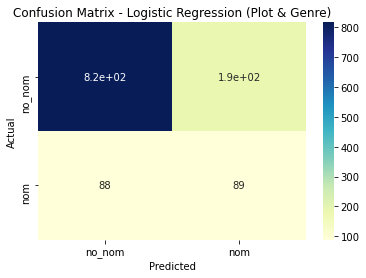

In [37]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=["no_nom", "nom"], columns=["no_nom", "nom"])

heatmap = sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title("Confusion Matrix - Logistic Regression (Plot & Genre)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('../../image_highlights/oscar_nomination_model/final_model_confusion_matrix_oscar_log_with_genre.png')
plt.show()

## Export 

In [35]:
import joblib



filename = os.path.join(
    "..", "..", "saved_models", "ratings_SVM_classifier.sav"
)
joblib.dump(model, filename)

filename = os.path.join(
    "..", "..", "flask_app", "ratings_SVM_classifier.sav"
)
joblib.dump(model, filename)